In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 把它转换成 tensor，映射到0到1之间的浮点数 因为一开始读进来可能是numpy的
# transforms.Normalize(mean, std) 表示将图像的每个通道（R、G、B）的像素值分别减去0.5并除以0.5
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# 每次测试或小批量训练的样本数为 4
batch_size = 4

# 训练集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# shuffle=True表示在每个epoch训练之前对数据进行洗牌 num_workers=2表示使用2个子进程来加载数据
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# 测试集
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## resnet 网络搭建
1. 主分支与shortcut分支的输出矩阵shape必须相同。
2. 第一层卷积后relu，第二层卷积之后不relu，相加后再relu。
3. 实线是shape相同的，虚线是表示不相同的（再来一次卷积使二者shape相同，可以相加）。
4. 卷积核的数量确实对应着输出通道的个数。在卷积操作中，每个卷积核对应一个输出通道。（1×1卷积核用来实现降维）
5. 调整步长可以对输出特征图的尺寸和感受野进行控制。步长为2，变成原图的一半。
6. BN ：使每一批 batch （不是一张图片，是一批图片。对每个通道进行处理。）标准化。加速网络的训练并提升准确率

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Downsample(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Downsample, self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=2, padding=0)
        self.bn = nn.BatchNorm2d(out_channel)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class BasicBlock(nn.Module):
    """
    ResNet-18、ResNet-34
    """
    # 删掉 不实现 resnet50 了
    # # 记录每个残差块的卷积核个数是否有变化
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1, flag=False):
        """
        :param flag: 下采样
        """
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        # conv2的 in_channels 应该是 out_channel！！
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        # self.downsample = None
        # 下采样方法
        self.flag = flag
        self.downsample = None
        if self.flag is True:
            self.downsample = Downsample(in_channel, out_channel)

    # def my_downsample(self, x, d_in_channel, d_out_channel):
    #     self.ds_conv = nn.Conv2d(d_in_channel, d_out_channel, kernel_size=(1, 1), stride=(2, 2), padding=0)
    #     self.ds_batch_normal = nn.BatchNorm2d(d_out_channel)

    def forward(self, x):
        # shortcut分支
        identity = x
        if self.flag is True:
            identity = self.downsample(x)
        # res block
        out = self.conv1(x)

        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)
        return out

# class BottleNeck(nn.Module):
#     """
#
#     """
class ResNet(nn.Module):
    """
    resnet
    """
    def __init__(self, block_num=1, num_classes=10):
        super(ResNet, self).__init__()
        # 输入特征矩阵的深度
        # self.in_channel = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1,
                               padding=3, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # resnet
        self.layer1 = BasicBlock(64, 64, 1)
        self.layer2 = BasicBlock(64, 128, 2, True)
        self.layer3 = BasicBlock(128, 128, 1)
        self.layer4 = BasicBlock(128, 256, 2, True)
        # self.layer1 = self._make_layer(block, 64, blocks_num[0])
        # self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        # self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        # self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        #
        #self.fc1 = nn.Linear(, num_classes)
        self.fc1 = nn.Linear(4096, 1000)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(1000, 100)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(100, num_classes)


    # def _make_layer(self, block, channel, block_num, stride=1):
    #     """
    #     :param block: ResNet-18＆ResNet-34 或 ResNet-50（未实现）
    #     :param channel: 一个残差结构中 卷积层的卷积核个数
    #     :param block_num: 一个 conv 结构中 残差结构的个数
    #     """
    #     downsample = None
    #     # ResNet-18＆ResNet-34 第一层不会执行
    #     if stride != 1 or self.in_channel != channel * block.expansion:
    #         # 生成下采样函数
    #         downsample = nn.Sequential(
    #             nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1,stride=stride,bias=False),
    #             nn.BatchNorm2d(channel * block.expansion)
    #         )
    #     layers = []
    #     # 传入第一层 block
    #     layers.append(block(self.in_channel, channel, downsample=downsample, stride=stride))
    #
    #     self.in_channel = channel * block.expansion
    #     # 剩余
    #     for _ in range(1, block_num):
    #         # ResNet-18＆ResNet-34 in_channel 一直是 64
    #         layers.append(block(self.in_channel, channel))
    #
    #     return nn.Sequential(*layers)

    def forward(self, x):
        #print("Input shape:", x.shape)
        x = self.conv1(x)
        #print("After conv1 shape:", x.shape)
        x = self.bn1(x)
        #print("After bn1 shape:", x.shape)
        x = self.relu1(x)
        #print("After relu shape:", x.shape)
        x = self.maxpool(x)
        #print("After maxpool shape:", x.shape)

        x = self.layer1(x)
        #print("After layer1 shape:", x.shape)
        x = self.layer2(x)
        #print("After layer2 shape:", x.shape)
        x = self.layer3(x)
        #print("After layer3 shape:", x.shape)
        x = self.layer4(x)
        #print("After layer4 shape:", x.shape)
        #x = self.fc1(x)
        #print("After fc1 shape:", x.shape)
        x = torch.flatten(x, 1)
        x = self.relu2(self.fc1(x))
        x = self.relu3(self.fc2(x))
        x = self.fc3(x)
        #print("After flatten shape:", x.shape)

        return x


In [4]:
resnet = ResNet()
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2

In [5]:
import torch.optim as optim
# 定义损失函数，交叉熵损失
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

## 训练

In [6]:
# 单个 epoch 的训练过程
def train(epoch):
    # Set model to training mode
    # 训练模式
    resnet.train()
    
    running_loss = 0.0
    correct = 0 # 正确预测的图片
    total = 0 # 总数
    cur_loss = 0
    
    # Loop over each batch from the training set
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        # 对损失函数进行反向传播
        loss.backward()
        # Update weights
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        cur_loss += loss.item()
#         # 计算每轮预测正确的图片及图片总数
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
                
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'Train Epoch:{epoch }  [{i - 1999:5d}, {i + 1:5d}] loss: {running_loss / 2000:.3f} accuracy:{correct / total * 100}')      
            running_loss = 0.0

In [9]:
# 用于在验证集上评估训练好的模型的性能
def validate(loss_vector, accuracy_vector):
    # 将模型设置为评估模式
    resnet.eval()
    val_loss, correct = 0, 0
    # 循环
    for data, target in testloader:
#         data = data.to(device)
#         target = target.to(device)
        output = resnet(data)
    
        # 损失累加到 val_loss 变量中
        val_loss += criterion(output, target).data.item()
        # 预测
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
    # 在循环结束后，计算整个验证集上的平均损失，并将其附加到 loss_vector 列表中。
    # 计算模型在整个验证集上的精度，并将其附加到 accuracy_vector 列表中。
    # 函数最后会打印出平均损失和精度。
    val_loss /= len(testloader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(testloader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(testloader.dataset), accuracy))

In [10]:
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch:1  [    0,  2000] loss: 1.560 accuracy:43.262499999999996
Train Epoch:1  [ 2000,  4000] loss: 1.401 accuracy:46.29375
Train Epoch:1  [ 4000,  6000] loss: 1.293 accuracy:48.583333333333336
Train Epoch:1  [ 6000,  8000] loss: 1.200 accuracy:50.834375
Train Epoch:1  [ 8000, 10000] loss: 1.108 accuracy:52.87
Train Epoch:1  [10000, 12000] loss: 1.046 accuracy:54.541666666666664

Validation set: Average loss: 0.9513, Accuracy: 6665/10000 (67%)

Train Epoch:2  [    0,  2000] loss: 0.942 accuracy:66.5
Train Epoch:2  [ 2000,  4000] loss: 0.901 accuracy:67.51875000000001
Train Epoch:2  [ 4000,  6000] loss: 0.871 accuracy:68.22083333333333
Train Epoch:2  [ 6000,  8000] loss: 0.834 accuracy:68.9875
Train Epoch:2  [ 8000, 10000] loss: 0.848 accuracy:69.355
Train Epoch:2  [10000, 12000] loss: 0.817 accuracy:69.73958333333333

Validation set: Average loss: 0.8926, Accuracy: 6954/10000 (70%)

Train Epoch:3  [    0,  2000] loss: 0.687 accuracy:75.8875
Train Epoch:3  [ 2000,  4000] loss: 0.6

KeyboardInterrupt: 

0.772

80

<Figure size 500x300 with 0 Axes>

Text(0.5, 1.0, 'validation loss')

<Figure size 500x300 with 0 Axes>

Text(0.5, 1.0, 'validation accuracy')

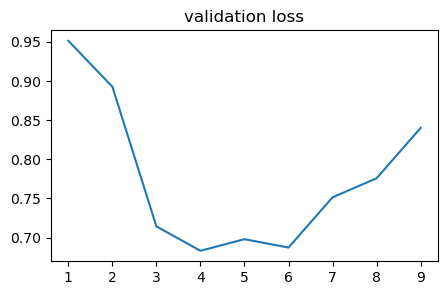

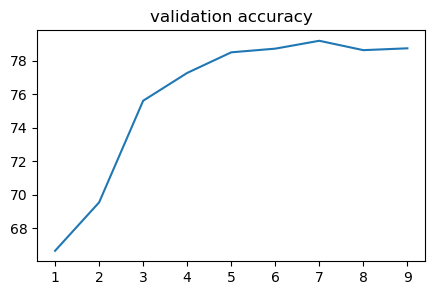

In [14]:
# 损失
lossv[8] = 0.8400
lossv.pop()
accv.pop()
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs), lossv)
plt.title('validation loss')
# 准确率
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs), accv)
plt.title('validation accuracy')